In [1]:
# Gerekli kütüphaneleri ve modülleri içe aktarıyoruz
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping hatasını önlemek için burada tanımlıyoruz

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [2]:
# ==========================================
# 1. VERİ YÜKLEME VE ÖN İŞLEME
# ==========================================

data_dir = 'panel_data' 

# Temel parametreler
batch_size = 32
img_height = 224
img_width = 224
random_seed = 42

print("Eğitim (Training) veri seti yükleniyor (%70)...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=random_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Doğrulama (Validation) veri seti yükleniyor (%30)...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=random_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Eğitim (Training) veri seti yükleniyor (%70)...
Found 3632 files belonging to 2 classes.
Using 2543 files for training.
Doğrulama (Validation) veri seti yükleniyor (%30)...
Found 3632 files belonging to 2 classes.
Using 1089 files for validation.


In [3]:
# Veri akışını hızlandırmak için önbellekleme ayarları
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# ==========================================
# 2. MODEL MİMARİSİ (ASFANDIYOR - BASE MODEL 3)
# ==========================================
# Açıklama: Standart 3x3 filtreler yerine 5x5 boyutunda filtreler kullanılır.
# Amaç: Daha büyük filtrelerin, görüntüdeki daha geniş alanlı özellikleri (örneğin büyük toz lekeleri)
# yakalamadaki etkisini gözlemlemek.

model = models.Sequential([
  # Normalizasyon (Piksel değerlerini 0-1 aralığına çekme)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # 1. Konvolüsyon Bloğu (FARK BURADA: 5x5 Filtre)
  layers.Conv2D(32, (5, 5), activation='relu'), 
  layers.MaxPooling2D(),
  
  # 2. Konvolüsyon Bloğu (FARK BURADA: 5x5 Filtre)
  layers.Conv2D(64, (5, 5), activation='relu'),
  layers.MaxPooling2D(),
  
  # Düzleştirme ve Tam Bağlantılı Katmanlar
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  
  # Çıkış Katmanı (İkili sınıflandırma)
  layers.Dense(1, activation='sigmoid')
])

# Model özetini görüntüle
model.summary()

c:\ProgramData\anaconda3\envs\My_new_env\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,505,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,559,489 (44.10 MB)

 Trainable params: 11,559,489 (44.10 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ==========================================
# 3. MODEL DERLEME
# ==========================================

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall')])

In [6]:
# ==========================================
# 4. EĞİTİM (TRAINING)
# ==========================================

# Early Stopping: Model iyileşmeyi durdurursa eğitimi erken keser
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 30

print("Eğitim başlıyor (5x5 Filtre Modeli)...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

Eğitim başlıyor (5x5 Filtre Modeli)...
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 676ms/step - accuracy: 0.5578 - loss: 1.4459 - precision: 0.5405 - recall: 0.7035 - val_accuracy: 0.6722 - val_loss: 0.6591 - val_precision: 0.6327 - val_recall: 0.8643
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.6816 - loss: 0.6001 - precision: 0.6760 - recall: 0.7551 - val_accuracy: 0.6970 - val_loss: 0.5891 - val_precision: 0.6681 - val_recall: 0.8161
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 631ms/step - accuracy: 0.7837 - loss: 0.4749 - precision: 0.7872 - recall: 0.8109 - val_accuracy: 0.7273 - val_loss: 0.5663 - val_precision: 0.7573 - val_recall: 0.6911
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 618ms/step - accuracy: 0.8847 - loss: 0.3069 - precision: 0.8913 - recall: 0.8907 - val_accuracy: 0.7401 - val_loss: 0.6627 - val_precision: 0.7046 - val_recall: 0.8518
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 617ms/step - accuracy: 0.9356 - loss: 0.1610 - precision: 0.9455 - recall: 

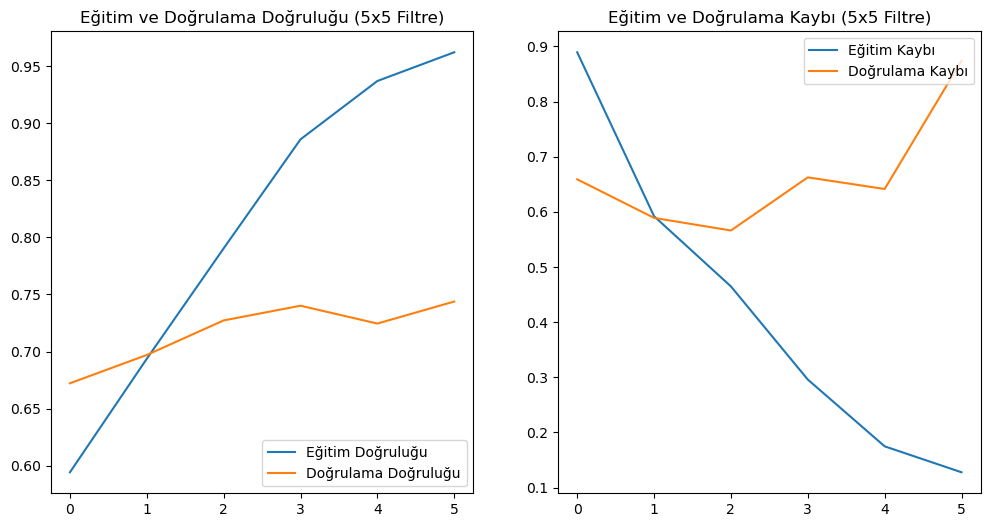

Model başarıyla kaydedildi: FET312_22040301121_PATtechs_model_3.h5


In [7]:
# ==========================================
# 5. SONUÇLAR VE GRAFİKLER
# ==========================================

# Eğitim geçmiş verilerini al
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu (5x5 Filtre)')

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı (5x5 Filtre)')
plt.show()

# Modeli kaydet
model_save_name = 'FET312_22040301121_PATtechs_model_3.h5'
model.save(model_save_name)
print(f"Model başarıyla kaydedildi: {model_save_name}")

Found 3632 files belonging to 2 classes.
Using 1089 files for validation.
Tahminler yapılıyor...


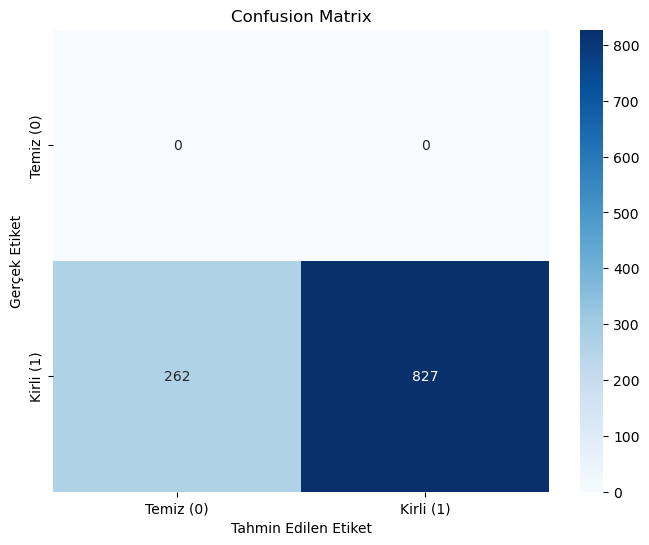


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

       Temiz       0.00      0.00      0.00         0
       Kirli       1.00      0.76      0.86      1089

    accuracy                           0.76      1089
   macro avg       0.50      0.38      0.43      1089
weighted avg       1.00      0.76      0.86      1089



c:\ProgramData\anaconda3\envs\My_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\My_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\My_new_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\a

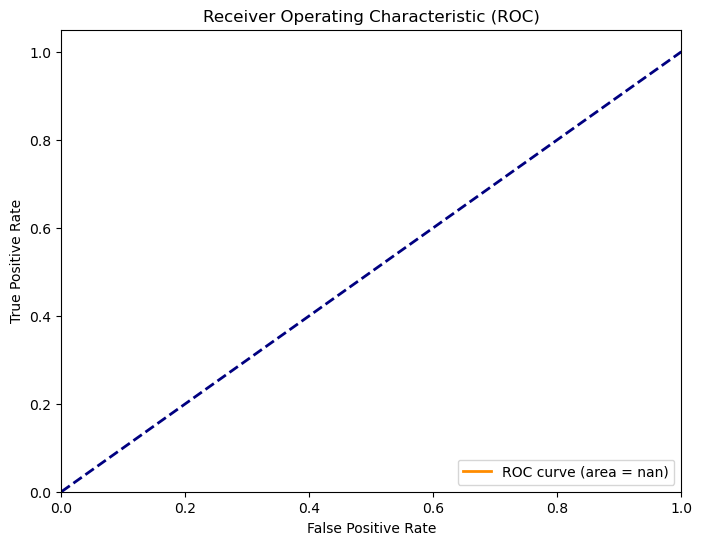

In [8]:
# ==========================================
# 6. DETAYLI PERFORMANS ANALİZİ
# ==========================================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Tahminleri üretmek için doğrulama setini tekrar alalım (Karıştırma olmadan!)
val_ds_eval = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False # ÖNEMLİ: Etiketlerin sırası bozulmasın diye shuffle kapalı
)

# Gerçek etiketleri ve tahminleri toplayalım
y_true = []
y_pred_probs = []

print("Tahminler yapılıyor...")
for images, labels in val_ds_eval:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = (y_pred_probs > 0.5).astype(int) # Eşik değeri 0.5

# 1. Confusion Matrix (Karmaşıklık Matrisi)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Temiz (0)', 'Kirli (1)'], 
            yticklabels=['Temiz (0)', 'Kirli (1)'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report (F1-Score, Precision, Recall)
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred_classes, target_names=['Temiz', 'Kirli']))

# 3. ROC Eğrisi (Appendix için gerekli)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

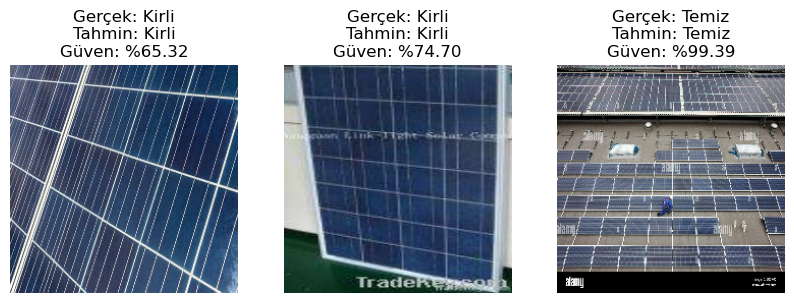

In [9]:
# ==========================================
# 7. TEKİL GÖRÜNTÜ TESTİ (DEMO)
# ==========================================

# Doğrulama setinden rastgele bir örnek al
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(3): # 3 örnek göster
        ax = plt.subplot(1, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        
        # Tahmin yap
        img_array = tf.expand_dims(images[i], 0) # Batch boyutu ekle
        prediction = model.predict(img_array, verbose=0)[0][0]
        
        true_label = "Kirli" if labels[i] == 1 else "Temiz"
        pred_label = "Kirli" if prediction > 0.5 else "Temiz"
        confidence = 100 * prediction if prediction > 0.5 else 100 * (1 - prediction)
        
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: %{confidence:.2f}")
        plt.axis("off")